## **Predicting Delaware Communities with High-Risk of Flash Floods**

## About Flash Floods

Flash floods are sudden and rapid flooding events that are caused by heavy rainfall, dam failure, or rapid snowmelt. They can occur in any geographic area, and are considered the number one storm-related killer in the United States [[1]](https://www.weather.gov/shv/awarenessweek_severe_flashflood#:~:text=Flash%20flooding%20is%20the%20number,they%20can%20safely%20make%20it.).

Flash floods can cause extensive damage to infrastructure and properties, as well as loss of life. The duration and intensity of flash floods can vary greatly, but they often occur within minutes to a few hours of intense rainfall.

For instance, on September 12, 2021, the city of Wilmington, DE experienced a flash flooding event that was largely a result of heavy rain that fell upstream in southeastern Pennsylvania, according to the National Weather Service. This led to the close to 40 Wilmington households! Others lost cars and furniture, or sustained damage to their homes [[2]](https://https://www.delawarepublic.org/politics-government/2021-09-12/your-guide-to-recovering-from-ida-flooding-in-wilmington-and-preparing-for-future-floods).

<img src='https://npr.brightspotcdn.com/dims4/default/fe5d91e/2147483647/strip/true/crop/538x404+0+0/resize/1760x1322!/format/webp/quality/90/?url=http%3A%2F%2Fnpr-brightspot.s3.amazonaws.com%2Flegacy%2Fsites%2Fwdde%2Ffiles%2F202109%2FSidney_Kellum_flood_ida_rescue_boat_wilmington_cropped.jpeg' width="500">

---

## Motivation

Predicting regions with high-risk of flash floods is crucial for mitigating the potential damage and loss of life. By identifying these regions, we can help emergency management agencies to take proactive measures to minimize the damage and loss of life caused by flash floods. In this study, we develop a machine learning model to predict regions with high-risk of flash floods in Delaware, by considering factors such as precipitation, land-use land-cover, elevation, socio-demographic characteristics, and FEMA flood data. We aim to contribute to improving the preparedness and resilience of Delaware's communities against flash floods. We integrate the socio-demographic characteristics with predictions to identify vulnerable communities at high-risk.

---

## Methodology

The study uses decision trees to predict the flooded regions. The features for the machine learning (ML) model are precipitation, elevation, and land-use & land-cover. The target for the model comes from the FEMA's model where the FEMA flood zones along with the precipitation event is used to identify the target labels. The model used on two datasets each containing 1000 random points in the state of Delaware. For the first dataset of 1000 points, three rainfall events are generated for each point resulting in 3000 points. The rest of the features and targets of the ML model are estimated at these points through interpolation and/or spatial join. The decision tree is first trained on 70% of the first dataset. It is then tested on the remaining 30% data. Next, a rainfall event from June 27, 2006 is used for testing purpose when using the second dataset of 1000 points.

[Image to Methodology FlowChart](https://drive.google.com/file/d/1LbqxcEQfM-uYcfjUNvEcJpk3iYYs_dV5/view?usp=sharing)



---


**NOTE:**

**The results and accuracies in the description corresponds to the stored dataframes** which is directly loaded in the **Decision Tree** section. The two dataframes with different sets of coordinates have been stored along with their corresponding features and targets. **If new data sets are to be tested, comment the first cell in the Decision Tree Section and then run the entire code**.

If the entire code is run and new datasets are generated, the numbers in the description may differ due to the randomly generated coordinates during the initial part of **Data Preparation For Machine Learning Models** section.

Also, we recommend using the stored dataframes to save the run time as some steps are computationally heavy due to large files.




---



**Set the fpath to the location of the data folder**

Link to data set
https://drive.google.com/drive/folders/12lTIuT6DUuFXRK8IVIvinpv6WS7_eOpU?usp=sharing

In [ ]:
fpath = '/content/drive/MyDrive/Delaware Flash Flood/Data'

### **Link google drive and install & load all necessary libraries.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 69.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 85.4 MB/s eta 0:00:00


In [ ]:
!pip install netCDF4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 39.1 MB/s eta 0:00:00


In [ ]:
!pip install basemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 860.6/860.6 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 4.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import random
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import box
from pyproj import Proj, CRS, transform
import xarray as xr
from scipy.interpolate import griddata
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
import graphviz
from sklearn.tree import export_graphviz
import pickle
import gzip, pickle, pickletools
from netCDF4 import Dataset as NetCDFFile
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib.patches as patches
from mpl_toolkits.basemap import Basemap
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve

In [ ]:
def PickleObj(obj, filepath):
    with gzip.open(filepath, "wb") as f:
        pickled = pickle.dumps(obj)
        optimized_pickle = pickletools.optimize(pickled)
        f.write(optimized_pickle)
def UnpickleObj(filepath):
    with gzip.open(filepath, 'rb') as f:
        p = pickle.Unpickler(f)
        obj = p.load()
    return obj

# **Data Preparation For Machine Learning Models**

The code snippet below is used to generate the collection of random points.

https://medium.com/@DakaiZhou/generate-random-location-coordinates-within-given-area-with-python-1d6e62b6e382

In [ ]:
def generate_random_location_within_ROI(num_pt, polygon):
  """
  Generate num_pt random location coordinates .
  :param num_pt INT number of random location coordinates
  :param polygon geopandas.geoseries.GeoSeries the polygon of the region
  :return x, y lists of location coordinates, longetude and latitude
  """
  # define boundaries
  bounds_all = polygon.bounds
  minx = min(bounds_all.minx)
  maxx = max(bounds_all.maxx)
  miny = min(bounds_all.miny)
  maxy = max(bounds_all.maxy)

  i = 0
  x = []
  y = []
  while i < num_pt:
    # generate random location coordinates
    x_t = np.random.uniform(minx, maxx)
    y_t = np.random.uniform(miny, maxy)
    # further check whether it is in the city area
    for p in polygon:
      if Point(x_t, y_t).within(p):
        x.append(x_t)
        y.append(y_t)
        i = i + 1
        break

  return x, y

In [ ]:
delaware_state = gpd.read_file(f"{fpath}/State_Outline_Land/STATE_OUTLINE_LAND.shp")
delaware_state = delaware_state.to_crs(4326)
delaware_state_geo = delaware_state["geometry"]

In [ ]:
x, y = generate_random_location_within_ROI(1000, delaware_state_geo)

data_df = pd.DataFrame(zip(x, y), columns=['OX', 'OY'])
geometry = [Point(xy) for xy in zip(data_df["OX"], data_df["OY"])]
crs = CRS('EPSG:4326')
data_df = gpd.GeoDataFrame(data_df, crs=crs, geometry=geometry)

In [ ]:
x, y = generate_random_location_within_ROI(1000, delaware_state_geo)

data_df_New = pd.DataFrame(zip(x, y), columns=['OX', 'OY'])
geometry = [Point(xy) for xy in zip(data_df["OX"], data_df["OY"])]
crs = CRS('EPSG:4326')
data_df_New = gpd.GeoDataFrame(data_df_New, crs=crs, geometry=geometry)

## **Preparing Features and Targets**

In [ ]:
points_df = data_df
points_list = list(zip(list(points_df['OX']), list(points_df['OY'])))

Points data with new coordinates to test the prediction of the ML model on a complete new set of points

In [ ]:
points_df_new = data_df_New
points_list_new = list(zip(list(points_df_new['OX']), list(points_df_new['OY'])))

### **Features**

#### **Estimate Elevation Data**

In [ ]:
ncu = gpd.read_file(f"{fpath}/Elevation/NewCastle_Upper.shp")
ncl = gpd.read_file(f"{fpath}/Elevation/NewCastle_Lower.shp")
kt = gpd.read_file(f"{fpath}/Elevation/Kent.shp")
sx = gpd.read_file(f"{fpath}/Elevation/Sussex.shp")

In [ ]:
elev = pd.concat([ncu,ncl,kt,sx], axis=0).reset_index(drop=True)
elev = elev.to_crs(4326)

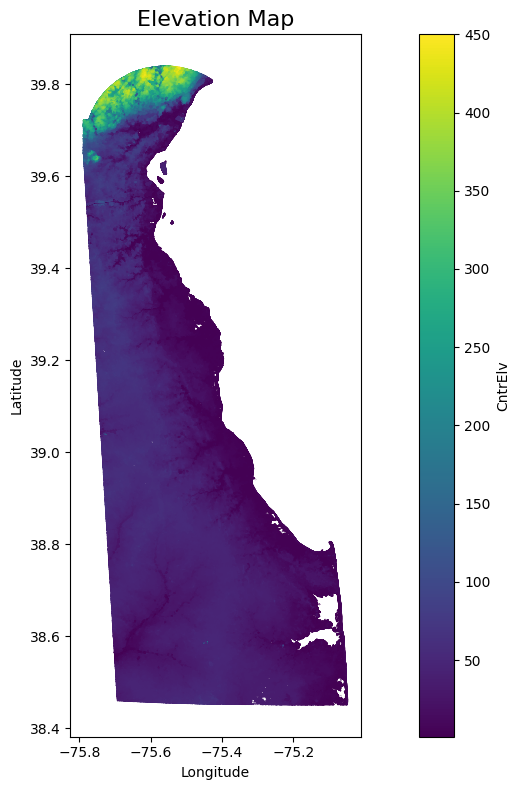

In [ ]:
elev['CntrElv'] = elev['CntrElv'].astype(float)
cmap = 'viridis'  # You can choose a different colormap if desired
fig, ax = plt.subplots(figsize=(12, 8))
elev.plot(ax=ax, column='CntrElv', cmap=cmap, linewidth=1)
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array(elev['CntrElv'])
plt.colorbar(sm, ax=ax, label='CntrElv')
ax.set_title('Elevation Map', fontsize=16)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()

Countour Elevation Data of Delaware(Here geometry is line and multi line strings).
-Most of the High elevated lands fall in the New Castle County)

In [ ]:
elev_points_dict = {}

# Skip some rows and points to reduce the size of the output file and reduce computational complexity
# As the density of points is very high, the accuracy of the output is not affected severly.
for i in range(0, len(elev), 4):
  try:
    line = elev.iloc[i]['geometry'].coords
    for j in range(0, len(line), 5):
      elev_points_dict[line[j]] = elev.iloc[i]['CntrElv']
  except:
    pass

In [ ]:
# create a GeoDataFrame from the dictionary
elev_points_gdf = gpd.GeoDataFrame.from_dict(elev_points_dict, orient='index', columns=['Cntr'], dtype='float')

# create new columns for latitude and longitude from the index
elev_points_gdf['Latitude'] = elev_points_gdf.index.map(lambda x: x[0])
elev_points_gdf['Longitude'] = elev_points_gdf.index.map(lambda x: x[1])

# reset the index to make the latitude and longitude columns regular columns
elev_points_gdf = elev_points_gdf.reset_index(drop=True)

**Interpolate Elevation**

In [ ]:
def create_elev_dict(data_df):
  # define the points and values for interpolation
  points = elev_points_gdf[['Latitude', 'Longitude']].values
  values = elev_points_gdf['Cntr'].values

  # define the random points for interpolation
  interp_points = data_df[['OX', 'OY']].values

  # interpolate the values at the random points
  interpolated = griddata(points, values, interp_points, method='linear')

  interp_dict = {tuple(point): value for point, value in zip(interp_points, interpolated)}

  return interp_dict

**Points Set 1**

In [ ]:
elev_dict = create_elev_dict(points_df)

**Points Set 2**

In [ ]:
elev_dict_new = create_elev_dict(points_df_new)

#### **Estimate Run-off Coefficient**

In [ ]:
#Reading land use land cover data and deleting unecessary columns

lc = gpd.read_file(f"{fpath}/LandUseLandCover/Delaware_Landuse_Landcover_Multiple_Years_.shp")
lc = lc.to_crs(4326)

lc = lc.drop(['NCC_RES_DE', 'LULC_COD_1', 'LULC_CAT_2','LULC_CATEG','LULC_CODE2'], axis=1)
lc = lc.rename(columns={'LULC_CAT_1': 'Land Type'})

In [ ]:
# Replace categories with generalized land types
lc['Land Type'] = lc['Land Type'].replace(['Mixed Single and Multi-Family Residential', 'Multi-Family Dwellings', 'Single Family Dwellings',
                                           'Mixed Urban or Built-up Land','Mobile Home Parks/Courts'], 'Residential')

lc['Land Type'] = lc['Land Type'].replace(['Commerical','Orchards/Nurseries/Horticulture','Marinas/Port Facilities/Docks'
                               'Confined Feeding Operations/Feedlots/Holding','Commercial',
                               'Transportation/Communication/Utilities','Institutional/Governmental','Extraction and Transitional'], 'Commercial')

lc['Land Type'] = lc['Land Type'].replace(['Deciduous Forest', 'Evergreen Forest', 'Mixed Forest'], 'Forest')

lc['Land Type'] = lc['Land Type'].replace(['Shrub/Brush Rangeland','Rangeland'], 'Grass')

lc['Land Type'] = lc['Land Type'].replace(['Forested Wetland - Tidal and Non-tidal','Scrub/Shrub Wetland - Tidal and Non-tidal',
                                           'Emergent Wetland - Tidal and Non-tidal','Open Water','Man-made Reservoirs and Impoundments'], 'Wetland')

lc['Land Type'] = lc['Land Type'].replace(['Sandy Areas and Shoreline'], 'Desert')

lc['Land Type'] = lc['Land Type'].replace(['Clear-cut'], 'Grass Poor')

lc['Land Type'] = lc['Land Type'].replace(['Farms, Pasture and Cropland'], 'Cultivated/Pasture Land')

lc['Land Type'] = lc['Land Type'].replace(['Recreational'], 'Parks/Sports Fields/Playgrounds')

lc['Land Type'] = lc['Land Type'].replace(['Confined Feeding Operations/Feedlots/Holding','Marinas/Port Facilities/Docks'], 'Commercial')

In [ ]:
#Assigning run off coefficients for each land type
runoff_values_dict = {'Residential': 0.48, 'Commercial': 0.8, 'Industrial': 0.77, 'Parks/Sports Fields/Playgrounds': 0.35,
                      'Cultivated/Pasture Land': 0.45, 'Grass': 0.43,'Forest': 0.6,'Wetland': 1,'Grass Poor': 0.47,'Desert': 0.43}

lc['Run off Coefficient'] = lc['Land Type'].map(runoff_values_dict)

Here is the reference link for above Run off coefficient values:https://civilweb-spreadsheets.com/drainage-design-spreadsheets/runoff-and-rainfall-intensity-calculator-spreadsheet/rational-method-runoff-coefficient/

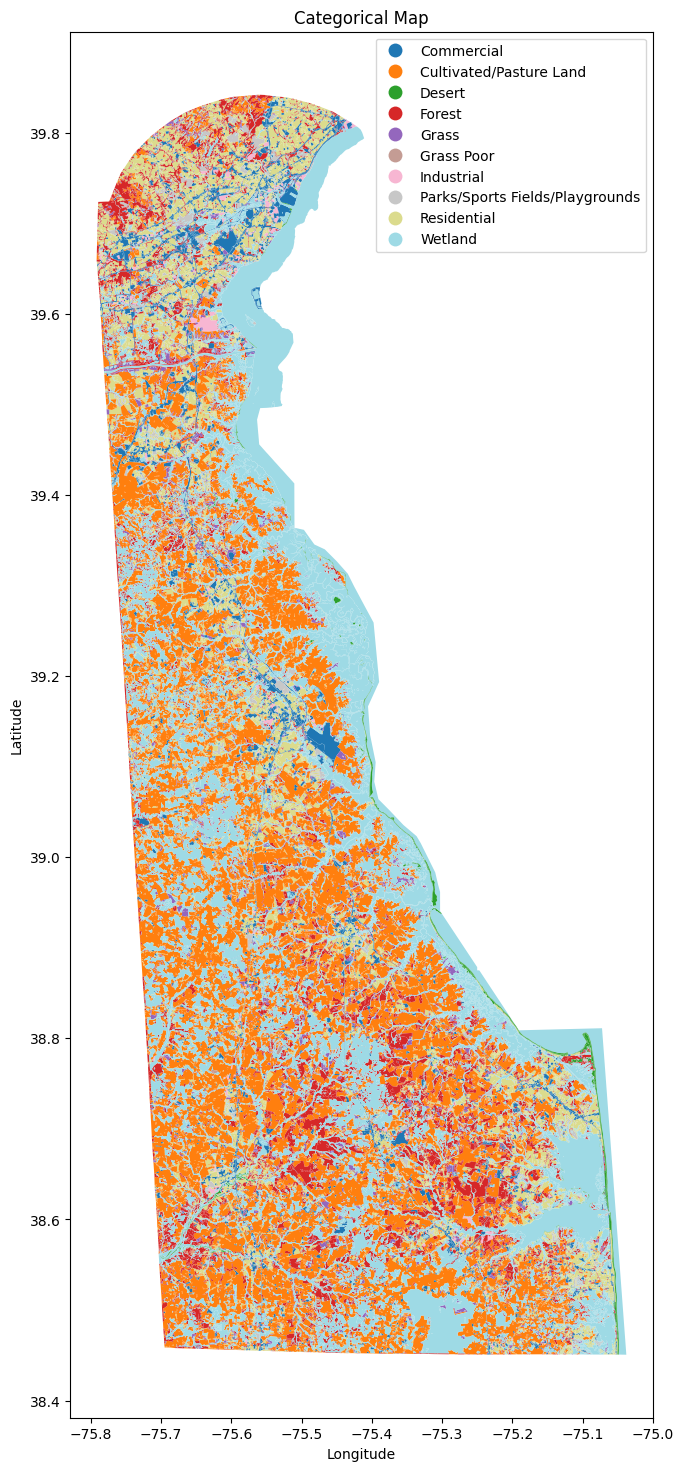

In [ ]:
# create the figure and axis
fig, ax = plt.subplots(figsize=(18, 18))

# plot the map
lc.plot(column='Land Type', cmap='tab20', ax=ax,legend=True)

# add title
ax.set_title('Categorical Map')

# add xand y label to the plot
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')


# display the chart
plt.show()

The above plot describes different types of land across the Delaware

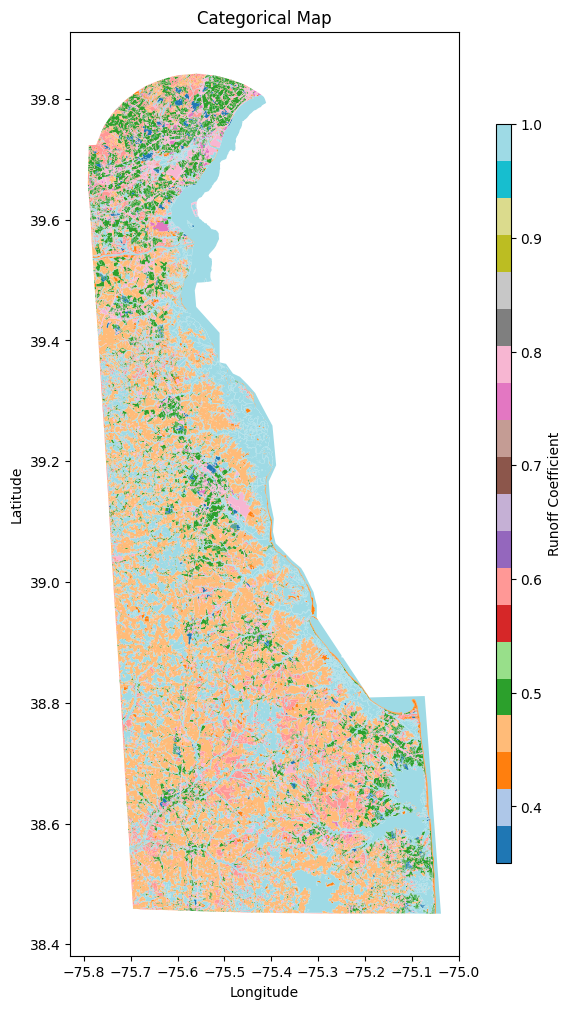

In [ ]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the map
lc.plot(column='Run off Coefficient', cmap='tab20', ax=ax, legend=True)

# Add title
ax.set_title('Categorical Map')

# Add x and y labels to the plot
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Remove the previous color bar if it exists
if len(fig.axes) > 1:
    fig.delaxes(fig.axes[1])

# Create a new color bar
cbar = fig.colorbar(ax.collections[0], aspect=50, shrink=0.8)

# Set the label for the color bar
cbar.set_label('Runoff Coefficient')

# Display the chart
plt.show()

Surface run off coefficient at different areas of Delaware

**Join Run-off data**

In [ ]:
#Method which gives a dictonary of points as keys and corresponding surface run off coefficient as values when passed a dataframe of random points

def create_coef_dict(points_df):
  # join the GeoDataFrame with lc using a left join
  join_left_df = points_df.sjoin(lc, how="left")

  # create a new column that is a tuple of OX and OY
  join_left_df['coords'] = join_left_df.apply(lambda row: (row['OX'], row['OY']), axis=1)

  # convert the DataFrame to a dictionary with coords as the key and Run off Coefficient as the value
  coef_dict = join_left_df.set_index('coords')['Run off Coefficient'].to_dict()

  return coef_dict

**Points Set 1**

In [ ]:
#Calling the above method
coef_dict = create_coef_dict(points_df)

**Points Set 2**

In [ ]:
coef_dict_new = create_coef_dict(points_df_new)

#### **Estimate Precipitation Data**

In [ ]:
# Precipitation data

ds = xr.open_dataset(f'{fpath}/Precipitation/CMORPH_V1.0_ADJ_0.25deg-DLY_00Z_20060627.nc')

In [ ]:
# As the rainfall amounts are less, intensify the rainfall 2.5 times to have a some labels show floods.
ds['cmorph'] = ds['cmorph']*3

In [ ]:
lat = np.array(ds['lat'])
lon = np.array(ds['lon'])

cmorph = np.array(ds['cmorph'])

In [ ]:
def mapformat():

  m = Basemap(projection='merc',llcrnrlon=-76, llcrnrlat=38, urcrnrlon=-74.5, urcrnrlat=40, resolution='i')

  m.drawcoastlines(color='k', linewidth=1)
  m.drawcountries(color='k', linewidth=1)
  m.drawstates(color='k', linewidth=1)

  m.drawparallels(np.arange(38,40,1), labels=[1,0,0,0], dashes=[1,1], linewidth=0.25, color='0.5')
  m.drawmeridians(np.arange(-75,-74,5.), labels=[0,0,0,1], dashes=[1,1], linewidth=0.25, color='0.5')

  return m

<ipython-input-167-0598d5d3f618>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  m.pcolormesh(x_, y_, cmorph[0], cmap=matplotlib.cm.get_cmap('viridis_r'), rasterized=True, edgecolor='0.6', linewidth=0, vmin=0, vmax=20)


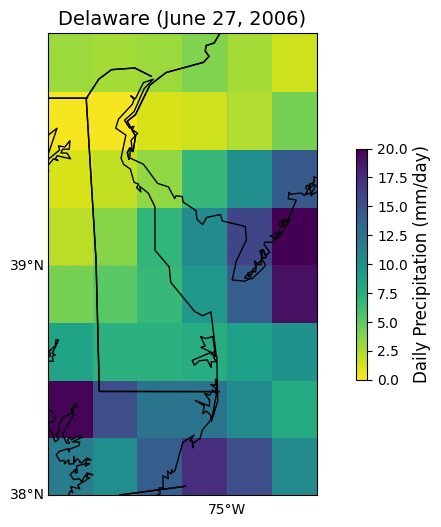

In [ ]:
plt.figure(figsize=(10, 6))

m = mapformat()

X, Y = np.meshgrid(lon-180, lat)
x_, y_ = m(X, Y)

m.pcolormesh(x_, y_, cmorph[0], cmap=matplotlib.cm.get_cmap('viridis_r'), rasterized=True, edgecolor='0.6', linewidth=0, vmin=0, vmax=20)
plt.title("Delaware (June 27, 2006)", fontsize=14)
cbar = plt.colorbar(shrink=0.5)
cbar.set_label('Daily Precipitation (mm/day)', rotation=90, fontsize=12)
plt.show()

**(GGD: A description of a spline of order 1 for the interpolation would be good to have here.  Could have also used a precipitation dataset for a larger region and used Gaussian Process Regression to do the interpolation.)**

**Interpolate Precipitation**

In [ ]:
def inter_p(lon_, lat_):
  ds_interpolated = ds.interp(lon=lon_+180, lat=lat_, method='slinear')

  for n, v in ds_interpolated.data_vars.items():
    if n == 'cmorph':
      val = v.values

  return val[0]

**Points Set 2**

In [ ]:
cmorph_values = {}
for p in points_list_new:
  cmorph_values[p] = inter_p(p[0], p[1])

#### **Social Vulnerability Index**

**(GGD: Need an in-depth discussion of what SVI is and how it is determined.)**

In [ ]:
svi = gpd.read_file(f'{fpath}/Sociodemographic characters/SVI2018_DELAWARE_tract.shp')
svi = svi.to_crs(4326)

**Join SVI values**

In [ ]:
svi_join_df = gpd.sjoin(points_df, svi, how='inner', predicate='within')

**Points Set 2**

In [ ]:
svi_dict = {}

for idx, row in svi_join_df.iterrows():
    point_coords = (row['geometry'].x, row['geometry'].y)
    rpl_value = row['RPL_THEMES']
    svi_dict[point_coords] = rpl_value

### **FEMA Flood Zone (to decide targets)**

In [ ]:
fz_newcastle = gpd.read_file(f'{fpath}/Flood_zones/S_FLD_HAZ_AR_NewCastle.shp')
fz_kent = gpd.read_file(f'{fpath}/Flood_zones/S_FLD_HAZ_AR_Kent.shp')
fz_sussex = gpd.read_file(f'{fpath}/Flood_zones/S_FLD_HAZ_AR_Sussex.shp')

In [ ]:
fz_newcastle = fz_newcastle.to_crs(4326)
fz_kent = fz_kent.to_crs(4326)
fz_sussex = fz_sussex.to_crs(4326)

In [ ]:
fz_merged = pd.concat([fz_newcastle[['FLD_AR_ID', 'FLD_ZONE', 'geometry']],
                       fz_kent[['FLD_AR_ID', 'FLD_ZONE', 'geometry']],
                       fz_sussex[['FLD_AR_ID', 'FLD_ZONE', 'geometry']]], ignore_index=True)

(-75.82734697170571, -74.98424022056855, 38.38159768070006, 39.908940315359125)

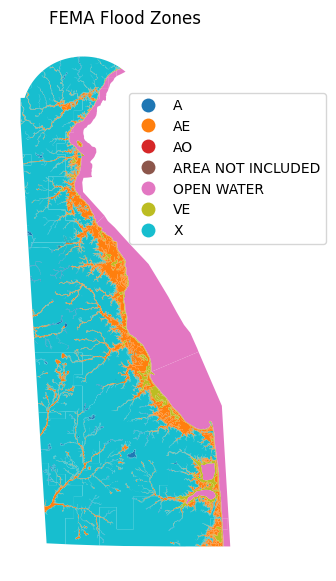

In [ ]:
# Plot FEMA zones

fig, ax = plt.subplots(figsize=(5, 7))

fz_merged.plot(column='FLD_ZONE', ax=ax, legend=True, legend_kwds={'bbox_to_anchor':(1.4, 0.9)})

ax.set_title("FEMA Flood Zones")
plt.axis('off')

**Points Set 1**

In [ ]:
points_fz_joined = points_df.sjoin(fz_merged, how="left").reset_index(drop=True)

In [ ]:
zone_labels = {}
for i in range(len(points_fz_joined)):
  p = (points_fz_joined['OX'][i], points_fz_joined['OY'][i])

  if p not in zone_labels:
    if points_fz_joined['FLD_ZONE'][i] in ['A', 'AE', 'VE']:
      zone_labels[p] = points_fz_joined['FLD_ZONE'][i]
    else:
      zone_labels[p] = 'X'

**Points Set 2**

In [ ]:
points_fz_joined_new = points_df_new.sjoin(fz_merged, how="left").reset_index(drop=True)

In [ ]:
zone_labels_new = {}
for i in range(len(points_fz_joined_new)):
  p = (points_fz_joined_new['OX'][i], points_fz_joined_new['OY'][i])

  if p not in zone_labels_new:
    if points_fz_joined_new['FLD_ZONE'][i] in ['A', 'AE', 'VE']:
      zone_labels_new[p] = points_fz_joined_new['FLD_ZONE'][i]
    else:
      zone_labels_new[p] = 'X'

#### **Create DataFrame with Features and Targets**

**Points Set 1**

In [ ]:
df_for_model = pd.DataFrame(columns=['OX', 'OY', 'CntrElv', 'Runoff', 'Precip', 'Label'])

count = 0
for i in range(len(points_df)):
  ox = points_df.loc[i]['OX']
  oy = points_df.loc[i]['OY']

  rcoeff = coef_dict[(ox, oy)]
  ctrelev = elev_dict[(ox, oy)]

  for j in range(3):
    prep = random.randrange(20)
    if zone_labels[(ox, oy)] == 'X':
      label = 0
    elif zone_labels[(ox, oy)] in ['A', 'AE', 'VE'] and prep <= 7.6:
      label = 0
    else:
      label = 1

    df_for_model.loc[count] = [ox, oy, ctrelev, rcoeff, prep, label]
    count += 1

In [ ]:
# PickleObj(df_for_model, 'df_for_model.pkl')

**Points Set 2**

In [ ]:
df_for_model_new = pd.DataFrame(columns=['OX', 'OY', 'CntrElv', 'Runoff', 'Precip', 'Label'])

count = 0
for i in range(len(points_df_new)):
  ox = points_df_new.loc[i]['OX']
  oy = points_df_new.loc[i]['OY']

  rcoeff = coef_dict_new[(ox, oy)]
  ctrelev = elev_dict_new[(ox, oy)]

  prep = cmorph_values[(ox, oy)]
  if zone_labels_new[(ox, oy)] == 'X':
    label = 0
  elif zone_labels_new[(ox, oy)] in ['A', 'AE', 'VE'] and prep <= 7.6:
    label = 0
  else:
    label = 1

  df_for_model_new.loc[count] = [ox, oy, ctrelev, rcoeff, prep, label]
  count += 1

In [ ]:
# PickleObj(df_for_model_new, 'df_for_model_new.pkl')

# **Decision Tree**

In [ ]:
# Points set 1
df_for_model = UnpickleObj(f'{fpath}/Pickle_files/df_for_model.pkl')
df_for_model = df_for_model.dropna(axis=0)

# Points set 2
df_for_model_new = UnpickleObj(f'{fpath}/Pickle_files/df_for_model_new.pkl')
df_for_model_new = df_for_model_new.dropna(axis=0)

## **Using Model With Default Parameters & no balancing**

In [ ]:
df_for_model = df_for_model.dropna(axis=0)

df_for_model_new = df_for_model_new.dropna(axis=0)

### **Part I (Using Point Set 1)**

Use a part of 'Points Set 1' to train the model and then test the model on remaining part of data.

In [ ]:
X = df_for_model[['CntrElv', 'Runoff', 'Precip']]
y = df_for_model['Label']

# Create a random training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

# Fit a decision tree classifier on the TRAINING data
model = DecisionTreeClassifier(random_state=10)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=10)

In [ ]:
# Assess the accuracy on the TRAINING & TESTING data
y_pred_train_NM = model.predict(X_train)
accuracy_train_NM = accuracy_score(y_train, y_pred_train_NM)
print(f"Accuracy (training): {accuracy_train_NM:.2f}")

y_pred_test_NM = model.predict(X_test)
accuracy_test_NM  = accuracy_score(y_test, y_pred_test_NM)
print(f"Accuracy (testing): {accuracy_test_NM:.2f}")

Accuracy (training): 1.00
Accuracy (testing): 0.97


In [ ]:
# Confusion Matrix
ConfM_test_NM = confusion_matrix(y_test, y_pred_test_NM)

In [ ]:
# Classification Report
CR_test_NM = pd.DataFrame(classification_report(y_test, y_pred_test_NM,  output_dict=True)).transpose()

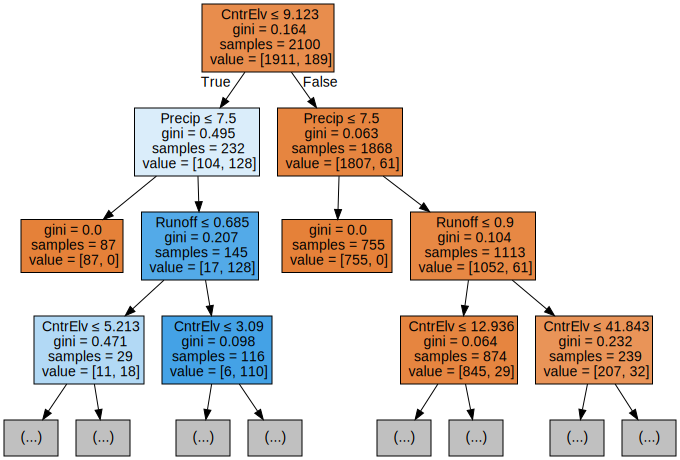

In [ ]:
# Visualize the tree
dt_data = export_graphviz(model, out_file=None, filled=True, rounded=False,
                          special_characters=True, max_depth=3, feature_names=X.columns)
graph = graphviz.Source(dt_data)
graph

### **Part II (Using Point Set 2)**

The coordinates in this dataset are completely different from the 1st set. We predict the output labels for different coordinates with different feature values.

In [ ]:
# To check that the two sets of data don't have common points

# points_set_2 = set(list(zip(list(df_for_model_new['OX']), list(df_for_model_new['OY']))))
# points_set_1 = set(list(zip(list(df_for_model['OX']), list(df_for_model['OY']))))

# print('The length of the intersection of the two data sets is', len(points_set_2.intersection(points_set_1)))

In [ ]:
X_new_NM = df_for_model_new[['CntrElv', 'Runoff', 'Precip']]
y_new_NM = df_for_model_new['Label']

# Assess the accuracy on the data
y_pred_new_NM = model.predict(X_new_NM)
accuracy_new_NM  = accuracy_score(y_new_NM, y_pred_new_NM)
print(f"Accuracy: {accuracy_new_NM:.2f}")

Accuracy: 0.93


The Decision Tree Classifier predicts 93% of the labels correctly for a completely new dataset.

In [ ]:
# Confusion Matrix
ConfM_New_NM = confusion_matrix(y_new_NM, y_pred_new_NM)

In [ ]:
# Classification Report
CR_New_NM = pd.DataFrame(classification_report(y_new_NM, y_pred_new_NM, output_dict=True)).transpose()

## **Modifying Parameters**

### **Part I (Using Point Set 1)**

**(GGD: The description in the link below not withstanding, this is <u>not</u> a sound method for balancing a data set as it will, in the general case, create duplicate rows.  A simple random oversampler of the minority class will [by definition] create duplicate rows of that minority class.  If you then randomly undersample the majority class, that will drop data, but those duplicate rows of the minority class *still exist*.  And so you may very well wind up with cases of identical copies in your training and testing sets those artifically boosting your test accuracy.  At the very least, you'd want to check your resultant data set for duplicates.)**

The data is resampled using oversampling and undersampling combined together. When used seperately, oversampling might lead to duplicates of minority class leading to overfitting and undersampling might lead to deletion of data from majority class leading to underfitting. However, if we combine the two methods, we can effectively balance the output [[1]](https://machinelearningmastery.com/combine-oversampling-and-undersampling-for-imbalanced-classification/#:~:text=Oversampling%20methods%20duplicate%20or%20create,of%20methods%20are%20used%20together).

In [ ]:
X = df_for_model[['CntrElv', 'Runoff', 'Precip']]
y = df_for_model['Label']

# Define undersampler & oversampler for balancing data
undersampler = RandomUnderSampler(random_state=10)
oversampler = RandomOverSampler(random_state=10)

# Define pipeline to perform oversampling and undersampling
pline = Pipeline(steps=[('o', oversampler), ('u', undersampler)])

# Balance data
X_resampled, y_resampled = pline.fit_resample(X, y)

In [ ]:
# Create a random training and testing set
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=10)

**Using Grid Search for tuning hyperparameters**

In [ ]:
# Select the parameter(s) to tune and the values to try
tuned_parameters = [{'min_samples_leaf': [1, 2, 5, 10, 20, 50, 100, 200, 500]}]

In [ ]:
# Perform Gridsearch
dtc_tune = DecisionTreeClassifier()
cv_tune = GridSearchCV(dtc_tune, tuned_parameters)

cv_tune.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid=[{'min_samples_leaf': [1, 2, 5, 10, 20, 50, 100, 200,
                                               500]}])

In [ ]:
cv_tune.best_params_

{'min_samples_leaf': 1}

In [ ]:
# Modify hyperparameter
dtc_mod = DecisionTreeClassifier(min_samples_leaf=cv_tune.best_params_['min_samples_leaf'])

# Fit model
dtc_mod.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
# Assess the accuracy on the TRAINING data
pred_tr_M = dtc_mod.predict(X_train)
acc_tr_M = accuracy_score(y_train, pred_tr_M)
print("training accuracy = {0:.3f}".format(acc_tr_M))

# Assess the accuracy on the TESTING data
pred_te_M = dtc_mod.predict(X_test)
acc_te_M = accuracy_score(y_test, pred_te_M)
print("testing accuracy = {0:.3f}".format(acc_te_M))

training accuracy = 1.000
testing accuracy = 0.998


In [ ]:
# Confusion Matrix
ConfM_test_M = confusion_matrix(y_test, pred_te_M)

In [ ]:
# Classification Report
CR_test_M = pd.DataFrame(classification_report(y_test, pred_te_M,  output_dict=True)).transpose()

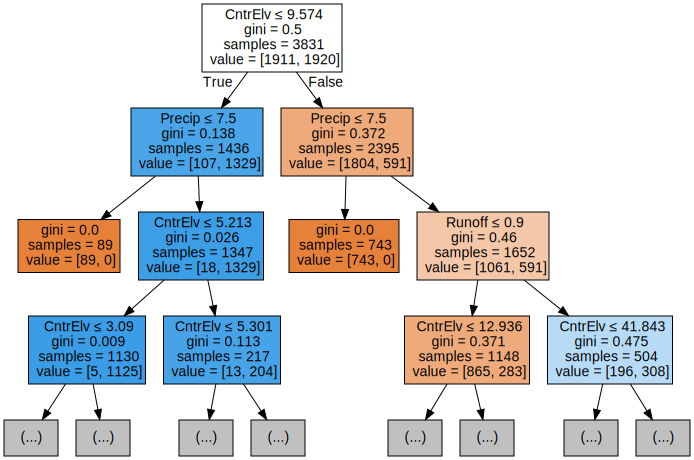

In [ ]:
# Visualize the tree
dt_data = export_graphviz(dtc_mod, out_file=None, filled=True, rounded=False,
                          special_characters=True, max_depth=3, feature_names=X.columns)
graph = graphviz.Source(dt_data)
graph

### **Part II (Using Point Set 2)**

The coordinates in this dataset are completely different from the 1st set. We predict the output labels for different coordinates with different feature values.

In [ ]:
X_new_M = df_for_model_new[['CntrElv', 'Runoff', 'Precip']]
y_new_M = df_for_model_new['Label']

# Assess the accuracy on the TRAINING & TESTING data
y_pred_new_M = dtc_mod.predict(X_new_M)
accuracy_new_M  = accuracy_score(y_new_M, y_pred_new_M)
print(f"Accuracy: {accuracy_new_M:.2f}")

Accuracy: 0.94


In [ ]:
# Confusion Matrix
ConfM_New_M = confusion_matrix(y_new_M, y_pred_new_M)

In [ ]:
# Classification Report
CR_New_M = pd.DataFrame(classification_report(y_new_M, y_pred_new_M, output_dict=True)).transpose()

### **Part III (Using Point Set 1)**

**(GGD: Exactly, very good!  However, for tree-based methods, having any duplicates is really not a good idea unless they really do exist in the data [and even then you'd want to think carefully about whether to remove them].
 The issue is that those duplicates will then have a greater impact on the tree than objects that aren't duplicated.)**

Adressing the oversampling problem:
-If we oversample the dataset there might be a case where same samples will be shared between training and testing sets.This leads to overfitting.So to address this problem we could initially split the dataset and the perform overfitting only on the training data and now the testing data will be new to the model.
-Used hypermeter tuning with 3 parameters using random searchCV.

In [ ]:
# Splitting the original data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Define undersampler & oversampler for balancing data
undersampler = RandomUnderSampler(random_state=10)
oversampler = RandomOverSampler(random_state=10)

# Define pipeline to perform oversampling and undersampling
pipline = Pipeline(steps=[('o', oversampler), ('u', undersampler)])

# Apply oversampling only on the training set
X_train_resampled, y_train_resampled = pipline.fit_resample(X_train, y_train)

In [ ]:
#Initialising the model

dtc_tune = DecisionTreeClassifier()

# Defining the parameter distributions
param_dist = {
    'min_samples_leaf': randint(1, 20),
    'min_samples_split': randint(2, 25),
    'max_depth': randint(5, 15)
}

# Create the RandomizedSearchCV object
cv_tune = RandomizedSearchCV(dtc_tune, param_distributions=param_dist, n_iter=20)

# Fit the model with the training data
cv_tune.fit(X_train_resampled, y_train_resampled)

RandomizedSearchCV(estimator=DecisionTreeClassifier(), n_iter=20,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fbc5fabb9a0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fbc5fabb7f0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fbc5faba1d0>})

In [ ]:
#These are the best Hyperparameters
cv_tune.best_params_

{'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 7}

In [ ]:
#Initilaising the model with the best parameters
vshdtc_mod = DecisionTreeClassifier(criterion='gini',max_depth=cv_tune.best_params_['max_depth'],min_samples_leaf=cv_tune.best_params_['min_samples_leaf'],min_samples_split=cv_tune.best_params_['min_samples_split'])
vshdtc_mod.fit(X_train_resampled,y_train_resampled)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=7)

In [ ]:
# Assess the accuracy on the TRAINING data
pred_tr_M_res = vshdtc_mod.predict(X_train_resampled)
acc_tr_M_res = accuracy_score(y_train_resampled, pred_tr_M_res)
print("training accuracy = {0:.3f}".format(acc_tr_M_res))

# Assess the accuracy on the TESTING data
pred_te_M_sh = vshdtc_mod.predict(X_test)
acc_te_M_sh = accuracy_score(y_test, pred_te_M_sh)
print("testing accuracy = {0:.3f}".format(acc_te_M_sh))

training accuracy = 0.965
testing accuracy = 0.923


In [ ]:
# Confusion Matrix
ConfM_test_M_upd = confusion_matrix(y_test, pred_te_M_sh)

In [ ]:
# Classification Report
CR_test_M_upd = pd.DataFrame(classification_report(y_test, pred_te_M_sh,  output_dict=True)).transpose()

### **Part IV (Using Point Set 2)**

In [ ]:
X_new_M = df_for_model_new[['CntrElv', 'Runoff', 'Precip']]
y_new_M = df_for_model_new['Label']

# Assess the accuracy on the new TESTING data
y_predS_new_M = vshdtc_mod.predict(X_new_M)
accuracy_new_M  = accuracy_score(y_new_M, y_predS_new_M)
print(f"Accuracy: {accuracy_new_M:.2f}")

Accuracy: 0.93


In [ ]:
# Confusion Matrix
ConfM_New_M_upd = confusion_matrix(y_new_M, y_predS_new_M)

In [ ]:
# Classification Report
CR_New_M_upd = pd.DataFrame(classification_report(y_new_M, y_predS_new_M, output_dict=True)).transpose()

# **Results**

### **Interpreting Results**

**Classification Reports**

In [ ]:
CR_test_NM = CR_test_NM.reset_index()
CR_test_NM['Name'] = ['TestData - Points Set I; No Modification' for i in range(5)]
CR_test_M = CR_test_M.reset_index()
CR_test_M['Name'] = ['TestData - Points Set I; Balanced Data & Modified Hyperparameters' for i in range(5)]
CR_test_M_upd = CR_test_M_upd.reset_index()
CR_test_M_upd['Name'] = ['TestData - Points Set I; Balanced Data & Additional Modified Hyperparameters' for i in range(5)]
CR_New_NM = CR_New_NM.reset_index()
CR_New_NM['Name'] = ['Points Set II; No Modification' for i in range(5)]
CR_New_M = CR_New_M.reset_index()
CR_New_M['Name'] = ['Points Set II; Balanced Data & Modified Hyperparameters' for i in range(5)]
CR_New_M_upd = CR_New_M_upd.reset_index()
CR_New_M_upd['Name'] = ['Points Set II; Balanced Data & Additional Modified Hyperparameters' for i in range(5)]

# Merge classification reports
frames = [CR_test_NM, CR_test_M, CR_test_M_upd, CR_New_NM, CR_New_M, CR_New_M_upd]
CR_ = pd.concat(frames)

In [ ]:
CR_Merged = CR_.set_index(['Name', 'index'])
CR_Merged

precision  \
Name                                               index                     
TestData - Points Set I; No Modification           0.0            0.982989   
                                                   1.0            0.779221   
                                                   accuracy       0.965556   
                                                   macro avg      0.881105   
                                                   weighted avg   0.966235   
TestData - Points Set I; Balanced Data & Modifi... 0.0            1.000000   
                                                   1.0            0.996341   
                                                   accuracy       0.998174   
                                                   macro avg      0.998171   
                                                   weighted avg   0.998181   
TestData - Points Set I; Balanced Data & Additi... 0.0            0.976879   
                                                   1.0            0.580247   
                                                   accuracy       0.923333   
                                                   macro avg      0.778563   
                                                   weighted avg   0.937876   
Points Set II; No Modification                     0.0            0.973517   
                                                   1.0            0.196429   
                                                   accuracy       0.930000   
                                                   macro avg      0.584973   
                                                   weighted avg   0.945542   
Points Set II; Balanced Data & Modified Hyperpa... 0.0            0.974657   
                                                   1.0            0.226415   
                                                   accuracy       0.935000   
                                                   macro avg      0.600536   
                                                   weighted avg   0.947720   
Points Set II; Balanced Data & Additional Modif... 0.0            0.983784   
                                                   1.0            0.280000   
                                                   accuracy       0.931000   
                                                   macro avg      0.631892   
                                                   weighted avg   0.958448   

                                                                   recall  \
Name                                               index                    
TestData - Points Set I; No Modification           0.0           0.979419   
                                                   1.0           0.810811   
                                                   accuracy      0.965556   
                                                   macro avg     0.895115   
                                                   weighted avg  0.965556   
TestData - Points Set I; Balanced Data & Modifi... 0.0           0.996368   
                                                   1.0           1.000000   
                                                   accuracy      0.998174   
                                                   macro avg     0.998184   
                                                   weighted avg  0.998174   
TestData - Points Set I; Balanced Data & Additi... 0.0           0.937153   
                                                   1.0           0.796610   
                                                   accuracy      0.923333   
                                                   macro avg     0.866882   
                                                   weighted avg  0.923333   
Points Set II; No Modification                     0.0           0.953320   
                                                   1.0           0.305556   
                                                   accuracy      0.930000   
                            

The precision for label 1 is less than 0 for all four cases. While precipitation amount and elevation are the two major factors that affect presence of floods, the output depends on a lot of other parameters and environmental factors.
* Case I (TestData - Points Set I; No modification): The model has a high an accuracy of 0.98. While the precision for label 0 is very high, the precision for label 1 is very low (0.78). This is due to very less data points were available for training of the model.
* Case II (TestData - Points Set I; Balanced Data & Modified Hyperparameters): The balancing of the data helps increase the number of samples for training. Combined with hyperparameter tuning, the overall accuracy (0.997) and precision for label 0 (1.00) and 1 (0.995) increases significantly.
* Case III (TestData - Points Set I; Balanced Data & Additional Modified Hyperparameters): Spliting the data before balancing decreases the accuracy of the model. This might be due to removal of repeated data points in testing.
* Case IV (Points Set II; No modification): The accuracy in this case seems to be high (0.93). However, when we look into the precision for label 0 and 1, there is a huge difference. The precision for label 1 is 0.196 due to two major reasons: (i) the training samples with label 1 is very less, and (ii) the geographic features for the points in second set is completely different which play a huge role in deciding flooded or not. Also, the model does not know if the given set of points lie inside the FEMA’s high-risk zone.
* Case V (Points Set II; Balanced Data & Modified Hyperparameters): The accuracy and precision increases slightly but is still very less for label 1.
* Case VI (Points Set II; Balanced Data & Additional Modified Hyperparameters): The accuracy is higher as compared to Case IV and V.


**(GGD: I think there may be one more case that would have been good to try here which was our final case in the model assessment section of the course, undersample the majority class to balance the data set from the beginning and then proceed as usual with hyperparameter tuning.  It is true that you would have very objects, but I'm not sure we've shown here yet whether data set size is an issue.)**

**Confusion Matrix**

[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

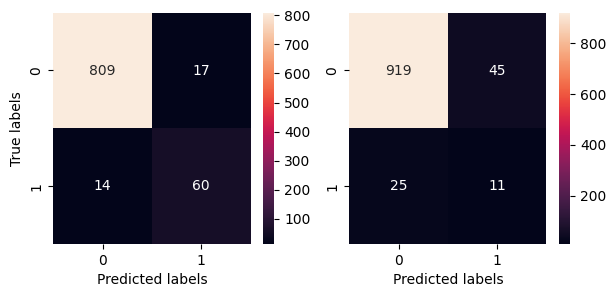

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
sns.heatmap(ConfM_test_NM, annot=True, fmt='g', ax=ax1)
sns.heatmap(ConfM_New_NM, annot=True, fmt='g', ax=ax2)

ax1.set_xlabel('Predicted labels')
ax2.set_xlabel('Predicted labels')
ax1.set_ylabel('True labels')
ax1.xaxis.set_ticklabels(['0', '1']); ax1.yaxis.set_ticklabels(['0', '1'])
ax2.xaxis.set_ticklabels(['0', '1']); ax2.yaxis.set_ticklabels(['0', '1'])

[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

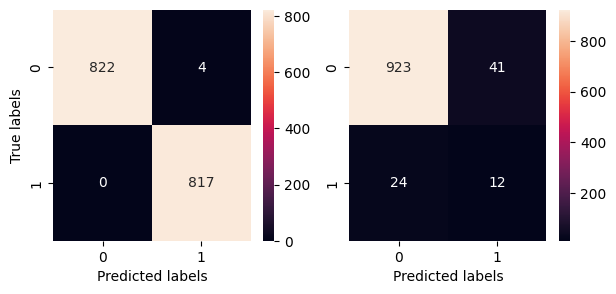

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
sns.heatmap(ConfM_test_M, annot=True, fmt='g', ax=ax1)
sns.heatmap(ConfM_New_M, annot=True, fmt='g', ax=ax2)

ax1.set_xlabel('Predicted labels')
ax2.set_xlabel('Predicted labels')
ax1.set_ylabel('True labels')
ax1.xaxis.set_ticklabels(['0', '1']); ax1.yaxis.set_ticklabels(['0', '1'])
ax2.xaxis.set_ticklabels(['0', '1']); ax2.yaxis.set_ticklabels(['0', '1'])

[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

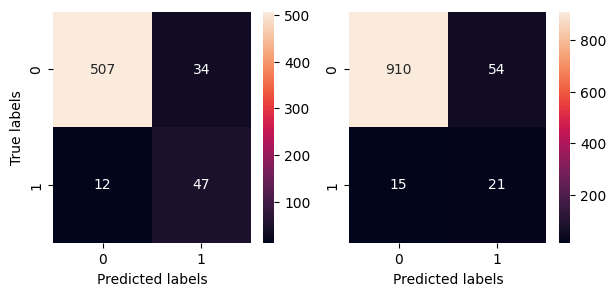

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
sns.heatmap(ConfM_test_M_upd, annot=True, fmt='g', ax=ax1)
sns.heatmap(ConfM_New_M_upd, annot=True, fmt='g', ax=ax2)

ax1.set_xlabel('Predicted labels')
ax2.set_xlabel('Predicted labels')
ax1.set_ylabel('True labels')
ax1.xaxis.set_ticklabels(['0', '1']); ax1.yaxis.set_ticklabels(['0', '1'])
ax2.xaxis.set_ticklabels(['0', '1']); ax2.yaxis.set_ticklabels(['0', '1'])

The confusion matrix model without modifications has high number of true negative values (0, 0). The true positive values in the prediction is lower for the second points set as compared with the first points set. The modified model performs better for the first points data set as the number of false positive and false negative is very less. However, the false positive and false negative is very less for the second points data set.



**ROC Curves for modiefied and not modified model.**

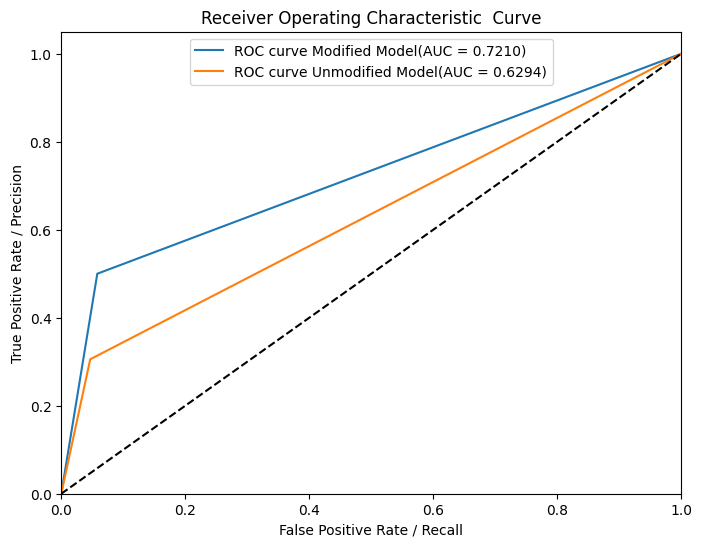

In [ ]:
# Calculate the false positive rate, true positive rate, and thresholds for the ROC curve for modified model
fpr_m, tpr_m, thresholds_m = roc_curve(y_new_M, y_pred_new_M)
roc_auc = auc(fpr_m, tpr_m)

# Calculate the false positive rate, true positive rate, and thresholds for the ROC curve for modified model
fpr_nm, tpr_nm, thresholds_nm = roc_curve(y_new_NM, y_pred_new_NM)
roc_auc_nm = auc(fpr_nm, tpr_nm)


# Plot both the ROC curve and the precision-recall curve on the same plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_m, tpr_m, label='ROC curve Modified Model(AUC = %0.4f)' % roc_auc)
plt.plot(fpr_nm, tpr_nm, label='ROC curve Unmodified Model(AUC = %0.4f)' % roc_auc_nm)
plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate / Recall')
plt.ylabel('True Positive Rate / Precision')
plt.title('Receiver Operating Characteristic  Curve')
plt.legend(loc='upper center')
plt.show()

There is clear difference between AUC of modified and unmodified model:
As the AUC depends of TPR=(TP/TP+FN) and FPR=FP/(TN+FP) from the confusion matrix of the Point Set 2 of unmodified and modified model TP increases  and FP decreases and TN increases  which result in increase of TPR and decrease of FPR which lead to increase of AUC

**Assessing Feature Importances**

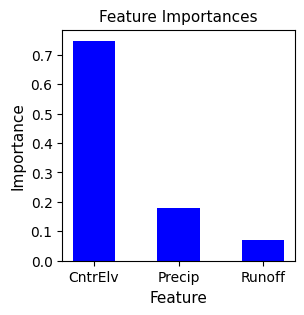

In [ ]:
# Calculate feature importances
importances = dtc_mod.feature_importances_
feature_names = X.columns

# Create a DataFrame of feature names and importances
feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
feature_df = feature_df.sort_values('Importance', ascending=False)
feature_df['Importance'] = pd.to_numeric(feature_df['Importance'])

plt.figure(figsize=(3, 3))
plt.bar(feature_df['Feature'], feature_df['Importance'], color='blue', width=0.5)

# Add labels
plt.xlabel('Feature', fontsize=11)
plt.ylabel('Importance', fontsize=11)
plt.title('Feature Importances', fontsize=11)
plt.show()

The feature importance scores indicate that the most important feature for predicting the risk of flooding is "CntrElv" (elevation of the point). This suggests that areas with lower elevations are at higher risk of flooding. The second most important feature is the amount of precipitation ("Precip"). This suggests that areas with higher levels of rainfall are also at higher risk of flooding.

### **Assessing the impact on communities**

In [ ]:
# load dataset
derm = gpd.read_file(f'{fpath}/Sociodemographic characters/SVI2018_DELAWARE_tract.shp')
derm = derm.to_crs(4326)

In [ ]:
points_new = df_for_model_new[['OX', 'OY']]
points_new['Prediction'] = y_pred_new_M

geometry = [Point(xy) for xy in zip(points_new["OX"], points_new["OY"])]
points_new = gpd.GeoDataFrame(points_new, crs=CRS('EPSG:4326'), geometry=geometry)

<ipython-input-221-82115fdbabde>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points_new['Prediction'] = y_pred_new_M


In [ ]:
#perform inner join
df1 = gpd.sjoin(points_new, derm, how='inner', predicate='within')

In [ ]:
merged_df = df1[['OX', 'OY', 'Prediction', 'geometry', 'RPL_THEMES', 'FIPS']]

In [ ]:
# Identify flooded CBGs
cbgs_flooded = list(set(list(merged_df[merged_df['Prediction']==1]['FIPS'])))

print('Census Blocks that may experience floods:')
print(cbgs_flooded)

Census Blocks that may experience floods:
['10005050401', '10005051301', '10005051004', '10005050902', '10005050705', '10005051400', '10005051305', '10005051003', '10005051202', '10005050803', '10005051302', '10005051801', '10005051500', '10005051201', '10005050706', '10005051303', '10005051006', '10005050901', '10005050704', '10005051701', '10005051005', '10005050103', '10005051007', '10005051702', '10005051900', '10005050802', '10005050701']


/usr/local/lib/python3.10/dist-packages/geopandas/plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/geopandas/plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


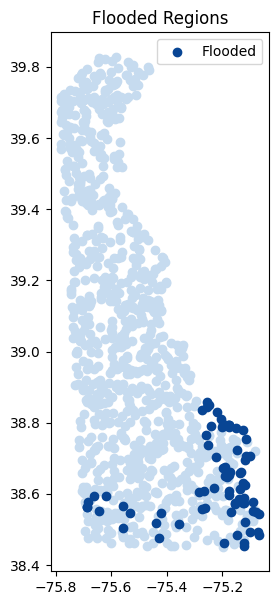

In [ ]:
# Plot chloropleth map
fig, ax = plt.subplots(figsize=(4, 7))
merged_df[merged_df['Prediction']==0].plot(column='Prediction', color='#c6dbef', ax=ax)
merged_df[merged_df['Prediction']==1].plot(column='Prediction', color='#084594', label='Flooded', ax=ax)
ax.set_title('Flooded Regions')
ax.legend()
plt.show()

# **Discussion & Conclusion**

The results for the four different cases show that the accuracy of the model is high when tested on the same data points used for training. The model is able to learn the complex relations between various features at these points. For a model without any modifications, while the accuracy for predicting label 0 is very high, the accuracy for predicting label 1 is low due to very less number of data points available for training. The accuracy increases when the data is balanced.

When the trained model is tested on a new dataset, we observe a significantly poor accuracy for label 1 as the models failed in learning the complex relations at new points. In addition, here are a lot of other factors/features that help decide the flooding status which are accounted by the FEMA model but not in the machine learning model used here. Therefore, the results make us think about the accuracy of the model when it comes to predicting regions with high risk of floods. Future studies can plan on using more features that affect the presence of floods to improve the accuracy of prediction of label 1.

The results help in identifying communities that might be prone to flooding. The model can be used by decision-makers to identify the regions and develop mitigation and rescue plans.